# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
#importing Mandatory modules
import torch
# importing nn to create model and optim create optimizer  
from torch import nn, optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
%matplotlib inline
import json

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
#set the directories
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), 
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [5]:
print(len(cat_to_name))
print(cat_to_name["1"])
cat_to_name

102
pink primrose


{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [6]:
# TODO: Building network

# Check if GPU is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Freeze all the parameters of the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Define a custom classifier to replace the original classifier of the pre-trained model
classifier = nn.Sequential(
    nn.Linear(25088, 1588),
    nn.ReLU(),
    nn.Linear(1588, 488),
    nn.ReLU(),                                 
    nn.Linear(488, 102), 
    nn.LogSoftmax(dim=1)
)

# Replace the original classifier with the custom classifier
model.classifier = classifier

# Define the loss metric
criterion = nn.NLLLoss()

# Define the optimizer and specify which parameters of the model should be updated
optimizer = optim.Adam(model.classifier.parameters(), lr=0.002)

# Move the model to the device (CPU or GPU)
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
#Training Model
epochs = 5
for e in range(1, epochs+1):
    # tracking number of batches in an epoch
    batch_counter = 0
    # tracking training loss (we want to see if its dropping or not), it's value is 0 , because we will add loss of each batch of training data in it
    training_loss = 0
    # accessing images from training set (every time this loop runs we get a batch(64) of images)
    for images, labels in trainloader:
        # shifting data to GPU (because we will train on GPU and our model will also be on GPU)
        images, labels = images.to(device), labels.to(device)
        # every time we get a batch(64) of images we increase batch_counter by 1
        batch_counter += 1
        # Now we are getting started with training, the first step is to set gradients to zero (to avoid any previously calculated gradients from previous batch)
        optimizer.zero_grad()
        # doing predictions on a batch 
        prediction = model(images) 
        # calculating loss(error in prediction (actual - predicted))
        loss = criterion(prediction, labels)
        # calculating the gradients of loss with respect to weights (to obtain value which should be subtracted from the previously used weights)
        loss.backward()
        # calculating new weights (by subtracting the previously calculated value from(loss.backward() from previously used weights))
        optimizer.step()
        # adding up loss calculated for one batch into a variable training_loss (which is tracking the training loss) 
        training_loss += loss.item()

        # Now we want to show the training loss after some batches of an epoch (so we are setting a condition batch_counter % 30 == 0, so that means we will show loss after every 30 batches because 30%30 = 0 and then 60%30 = 0 and so on)
        if batch_counter % 30 == 0:
            # shifting our model to testing mode , So that it can avoid any dropout layers and use each of its neurons
            model.eval()
            # besides training_loss we will display accuracy on validation data also, So that's why creating a tracker for this and setting it's value to 0 , because we will add accuracy of each batch of validation data in it
            testing_accuarcy = 0
            # besides training_loss and validation accuracy we will show the validation loss also, So that's why creating a tracker for this and setting it's value to 0 , because we will add loss of each batch of validation data in it
            testing_loss = 0
            # restricting pytorch to calculate gradients as we are not training , just doing predictions
            with torch.no_grad():
                # accessing data from validation set and we will use all of the data from this set
                for images_test, labels_test in validloader:
                    # shifting data to GPU because model is on GPU 
                    images_test, labels_test = images_test.to(device) , labels_test.to(device)
                    # doing prediction on one batch of validation set
                    prediction_test = model(images_test)
                    # calculating loss for one batch and adding it to tracker
                    testing_loss += criterion(prediction, labels)
                    # calculating exponetial probabilities (that means smaller will becaome really small and larger will becaome really large)
                    prediction_exp_prob_test = torch.exp(prediction_test) 
                    # getting indexes(classes(categories of flowers)) of highest prababilities
                    actual_highest_value_test, index_of_highest_values_test = prediction_exp_prob_test.topk(1)
                    # "index_of_highest_values_test == labels_test.view(*index_of_highest_values_test.shape" will give us a vector of 64 values which can be 1 or 0 , as 1 being a correct prediction and 0 being a wrong prediction, and we will do this for every batch of validation set
                    # comparing the actual and predicted and then calculating the sum of it, this will give us the total correct predictions on validation set and then we can calculate accuracy as dividing it by total no. of images(data) in validation loader
                    comparison_test =(index_of_highest_values_test == labels_test.view(*index_of_highest_values_test.shape)).sum().item()
                    # adding the no. of correct predictions our model did on one batch of validation set in testing_accuracy(it will contain total no. of correct predictions for whole validation set)
                    testing_accuarcy += comparison_test

            # printing all        
            print(f"Epoch: {e} | Batch: {batch_counter} | Training loss: {round(training_loss, 2)} | Validation loss: {round((testing_loss/len(validloader)).item(), 2)} | Validation Accuracy: {round(testing_accuarcy/len(validloader.dataset)*100, 2)}")
            print("----------------------------------------")
            # setting training loss to zero because we want to see the loss for next 30 batches and it should be decreasing if model is learning well (as it will make better and better predictions so loss will be smaller and smaller)
            training_loss = 0


Epoch: 1 | Batch: 30 | Training loss: 141.34 | Validation loss: 3.28 | Validation Accuracy: 27.75
----------------------------------------
Epoch: 1 | Batch: 60 | Training loss: 81.12 | Validation loss: 2.28 | Validation Accuracy: 49.76
----------------------------------------
Epoch: 1 | Batch: 90 | Training loss: 58.44 | Validation loss: 1.8 | Validation Accuracy: 62.22
----------------------------------------
Epoch: 2 | Batch: 30 | Training loss: 45.5 | Validation loss: 1.55 | Validation Accuracy: 70.78
----------------------------------------
Epoch: 2 | Batch: 60 | Training loss: 40.68 | Validation loss: 1.65 | Validation Accuracy: 75.79
----------------------------------------
Epoch: 2 | Batch: 90 | Training loss: 36.18 | Validation loss: 1.24 | Validation Accuracy: 75.92
----------------------------------------
Epoch: 3 | Batch: 30 | Training loss: 31.67 | Validation loss: 1.29 | Validation Accuracy: 77.26
----------------------------------------
Epoch: 3 | Batch: 60 | Training los

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [8]:
# TODO: Do validation on the test set
total_correct = 0
model.eval()

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        prediction = model(images)
        _, predicted = torch.max(prediction.data, 1)
        total_correct += (predicted == labels).sum().item()

accuracy = (total_correct / len(testloader.dataset)) * 100
print(f"Testing Accuracy: {accuracy:.2f}%")


Testing Accuracy: 82.05%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [9]:
# TODO: Save the checkpoint 
param_dict = {'input_size': 25088,
              'output_size': 102,
              'state_dict': model.state_dict()}

torch.save(param_dict, 'my_model.pth')

In [10]:
ls -lh

total 1.5G
drwxr-xr-x 2 root root 4.0K Apr  1  2019 assets/
-rw-r--r-- 1 root root 2.2K Mar  5  2018 cat_to_name.json
-rw-r--r-- 1 root root 1.3G Mar 20 09:57 checkpoint.pth
drwxr-xr-x 4 root root 4.0K Mar 20 10:44 data/
lrwxrwxrwx 1 root root   21 Oct 13  2018 flowers -> ../../../data/flowers/
-rw-r--r-- 1 root root  42K Mar 23 07:22 Image Classifier Project.ipynb
-rw-r--r-- 1 root root  16K Aug  5  2018 Image Classifier Project-zh.ipynb
-rw-r--r-- 1 root root 1.1K Feb  6  2018 LICENSE
-rw-r--r-- 1 root root 212M Mar 23 07:22 my_model.pth
-rw-r--r-- 1 root root    0 Feb  6  2018 predict.py
-rw-r--r-- 1 root root  250 Apr 20  2018 README.md
-rw-r--r-- 1 root root    0 Feb  6  2018 train.py
-rw-r--r-- 1 root root 1.6K Sep 28  2018 workspace-utils.py


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [11]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def build_model_again(model_path):
    param_dict = torch.load(model_path)
    model = models.vgg16(pretrained=True)
    classifier = nn.Sequential(nn.Linear(param_dict["input_size"], 1588),
                                     nn.ReLU(),
                                     nn.Linear(1588, 488),
                                     nn.ReLU(),                                 
                                     nn.Linear(488, param_dict["output_size"]), 
                                     nn.LogSoftmax(dim=1))
    model.classifier = classifier
    model.cuda()
    model.load_state_dict(param_dict['state_dict'])
    return model

model = build_model_again('my_model.pth')

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_correct = 0
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        prediction = model(images)
        prediction_exp_prob = torch.exp(prediction) 
        actual_highest_value, index_of_highest_values = prediction_exp_prob.topk(1)
        comparison =(index_of_highest_values == labels.view(*index_of_highest_values.shape)).sum().item()
        total_correct += comparison
print(f"testing_accuracy: {total_correct/len(testloader.dataset)*100}")

testing_accuracy: 82.05128205128204


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [13]:
def process_image(image):
    input_image = Image.open(image).resize((256, 256))
    
    input_image_transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    processed_image = input_image_transform(input_image)
    return processed_image


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [14]:
def display_img(image, ax=None, title=None):

    if ax is None:
        fig, ax = plt.subplots()

    # Convert tensor to numpy array and rearrange dimensions
    image = np.transpose(image.cpu().numpy(), (1, 2, 0))

    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip values between 0 and 1
    image = np.clip(image, 0, 1)

    # Plot the image
    ax.imshow(image)

    if title is not None:
        ax.set_title(title)

    return ax


In [15]:
ls -l

total 1484544
drwxr-xr-x 2 root root       4096 Apr  1  2019 assets/
-rw-r--r-- 1 root root       2218 Mar  5  2018 cat_to_name.json
-rw-r--r-- 1 root root 1297055929 Mar 20 09:57 checkpoint.pth
drwxr-xr-x 4 root root       4096 Mar 20 10:44 data/
lrwxrwxrwx 1 root root         21 Oct 13  2018 flowers -> ../../../data/flowers/
-rw-r--r-- 1 root root      42136 Mar 23 07:22 Image Classifier Project.ipynb
-rw-r--r-- 1 root root      15677 Aug  5  2018 Image Classifier Project-zh.ipynb
-rw-r--r-- 1 root root       1064 Feb  6  2018 LICENSE
-rw-r--r-- 1 root root  221530899 Mar 23 07:22 my_model.pth
-rw-r--r-- 1 root root          0 Feb  6  2018 predict.py
-rw-r--r-- 1 root root        250 Apr 20  2018 README.md
-rw-r--r-- 1 root root          0 Feb  6  2018 train.py
-rw-r--r-- 1 root root       1540 Sep 28  2018 workspace-utils.py


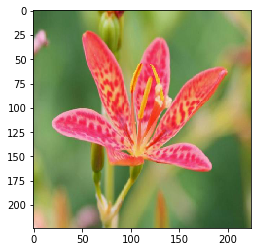

In [16]:
display_img(process_image("flowers/test/102/image_08015.jpg"))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [17]:
def predict(image_path, model=build_model_again('my_model.pth'), topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = process_image(image_path).unsqueeze(dim=0)
    model.eval().cpu()
    with torch.no_grad():
        prediction = model(image)
        prediction_exp_prob = torch.exp(prediction) 
        actual_highest_value, index_of_highest_values = prediction_exp_prob.topk(topk)
    return [index_of_highest_values, actual_highest_value]

In [18]:
predict("flowers/test/102/image_08015.jpg")

[tensor([[ 78,   4,  85,  55,  68]]),
 tensor([[ 0.7764,  0.1601,  0.0587,  0.0019,  0.0016]])]

In [19]:
predict("flowers/test/102/image_08015.jpg")[0][0]

tensor([ 78,   4,  85,  55,  68])

In [20]:
predict("flowers/test/102/image_08015.jpg")[1][0][4].item()

0.0015542212640866637

In [21]:
predict("flowers/test/102/image_08015.jpg")[1][0][0].item()

0.7764338254928589

In [22]:
prediction_result = predict("flowers/test/102/image_08015.jpg")
probs = prediction_result[1][0]
classes = prediction_result[0][0]

In [23]:
for i in classes:
    print(f"{i.item()}: {cat_to_name[str(i.item())]}")

78: lotus lotus
4: sweet pea
85: desert-rose
55: pelargonium
68: bearded iris


In [24]:
for i in range(5):
    print(f"{cat_to_name[str(prediction_result[0][0][i].item())]}: {round(prediction_result[1][0][i].item()*100, 2)}")

lotus lotus: 77.64
sweet pea: 16.01
desert-rose: 5.87
pelargonium: 0.19
bearded iris: 0.16


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [25]:
def plot_results(image):
    plt.subplot(2, 1, 1)
    imgplot = plt.imshow(mpimg.imread(image))
    prediction_result = predict(image)
    first_class = prediction_result[0][0][0].item()
    second_class = prediction_result[0][0][1].item()
    third_class = prediction_result[0][0][2].item()
    fourth_class = prediction_result[0][0][3].item()
    fifth_class = prediction_result[0][0][4].item()

    first_prob = prediction_result[1][0][0].item()
    second_prob = prediction_result[1][0][1].item()
    third_prob = prediction_result[1][0][2].item()
    fourth_prob = prediction_result[1][0][3].item()
    fifth_prob = prediction_result[1][0][4].item()

    y = [cat_to_name[str(first_class)], cat_to_name[str(second_class)], cat_to_name[str(third_class)], cat_to_name[str(fourth_class)], cat_to_name[str(fifth_class)]]

    x = [first_prob, second_prob, third_prob, fourth_prob, fifth_prob]
    plt.subplot(2, 1, 2)
    plt.barh(y, x)

    plt.show()

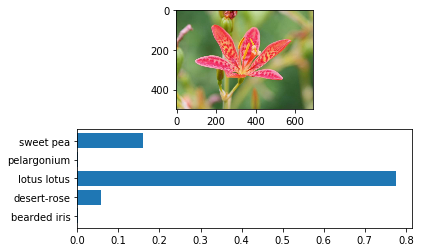

In [26]:
# prediction on a custom image (flower from my rooftop garden)
plot_results("flowers/test/102/image_08015.jpg")

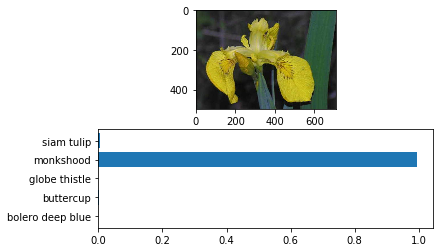

In [27]:
# prediction on a flower from validation set
plot_results("flowers/valid/15/image_06385.jpg")